# Yankees - Event Propensity - Next Tier Buyer
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ·····················


In [ ]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (f"""Exec [stlrYankees].[ds].[getPropensityEventScoring_new] {lkupclientid}""")

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

In [167]:
df = pd.read_csv('./yankees-data-export-tier.csv')
df.shape

(522560, 33)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522560 entries, 0 to 522559
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  522560 non-null  int64  
 1   lkupClientId                522560 non-null  int64  
 2   dimCustomerMasterId         522560 non-null  int64  
 3   eventName                   522560 non-null  object 
 4   inMarket                    522560 non-null  int64  
 5   year                        522560 non-null  int64  
 6   productGrouping             522560 non-null  object 
 7   Tier                        522560 non-null  int64  
 8   eventDay                    522560 non-null  int64  
 9   totalSpent                  522560 non-null  float64
 10  recentDate                  522560 non-null  object 
 11  attendancePercent           522560 non-null  float64
 12  renewedBeforeDays           522560 non-null  int64  
 13  isBuyer       

In [169]:
#profile = ProfileReport(df, minimal=True)
#profile.to_file(output_file="yankees_pandas_profile.html")

### We should specify the features used in our model:

In [170]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "attendancePercent",
        "click_link",
        "clickToSendRatio",
        "clickToOpenRatio",
        "distToVenue",
        "eventDay",
        "isBuyer",
        "isNextGameBuyer",
        "open_email" ,
        "openToSendRatio",
        "numAppViewsActivities",
        "numWebEngagementActivities",
        "recency",
        "recentDate",
        "renewedBeforeDays",
        "send_email",
        "source_tenure",
        #"Tier",
        "tenure",
        "totalGames",
        "totalSpent",
        "unsubscribe_email",
        "nextYearTier",
        "year"
]

# copy your main dataframe
df_dataset = df.sample(frac =0.25)

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2018]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (64082, 24)
Unseen Data For Predictions: (11308, 24)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [171]:
setup(
    data= df_train, 
    target="nextYearTier", 
    train_size = 0.80,
    data_split_shuffle=True,
    date_features=["recentDate"],
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "eventDay",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "isNextGameBuyer",
        "recency",
        "click_link",
        "open_email",
        "numAppViewsActivities",
        "numWebEngagementActivities",
        "send_email",
        #"Tier",
        "totalGames",
        "totalSpent",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [172]:
df_train['nextYearTier'].value_counts()

0    43286
4     7955
2     5986
3     4289
5     1582
1      984
Name: nextYearTier, dtype: int64

In [154]:
#df_train = df_train.sort_values('nextYearTier').reset_index()
#df_train = df_train.iloc[:,1000:]

#df_train['nextYearTier'].value_counts()

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256689 entries, 31546 to 38096
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   dimCustomerMasterId         256689 non-null  int64  
 1   attendancePercent           256689 non-null  float64
 2   click_link                  256689 non-null  int64  
 3   clickToSendRatio            256689 non-null  float64
 4   clickToOpenRatio            256689 non-null  float64
 5   distToVenue                 256689 non-null  float64
 6   eventDay                    256689 non-null  int64  
 7   isBuyer                     256689 non-null  bool   
 8   isNextGameBuyer             256689 non-null  int64  
 9   open_email                  256689 non-null  int64  
 10  openToSendRatio             256689 non-null  float64
 11  numAppViewsActivities       7090 non-null    float64
 12  numWebEngagementActivities  12953 non-null   float64
 13  recency    

In [180]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","xgboost"],
    sort="auc"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7212,0.8093,0.2961,0.6700,0.6633,0.3287,0.3611,0.6980
xgboost,Extreme Gradient Boosting,0.7252,0.8087,0.3091,0.6800,0.6718,0.3437,0.3743,11.5530


In [ ]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7205,0.8109,0.2883,0.6639,0.6603,0.3240,0.3576
1,0.7213,0.8060,0.2966,0.6667,0.6603,0.3211,0.3573
2,0.7182,0.8086,0.2910,0.6646,0.6609,0.3257,0.3555
3,0.7158,0.8096,0.2890,0.6523,0.6568,0.3174,0.3479
4,0.7254,0.8142,0.3014,0.6754,0.6688,0.3408,0.3733
5,0.7183,0.8058,0.2962,0.6729,0.6602,0.3198,0.3523
6,0.7263,0.8063,0.3070,0.6828,0.6698,0.3406,0.3742
7,0.7204,0.8063,0.2896,0.6630,0.6624,0.3272,0.3592
8,0.7234,0.8165,0.3055,0.6762,0.6692,0.3402,0.3699
9,0.7226,0.8090,0.2966,0.6824,0.6639,0.3302,0.3638


### Let's load in our 2021/2022 season data and get retention scores using the model:

In [174]:
df_inference = df.loc[df["year"] >= 2021].reset_index(drop=True)
df_inference = df_inference.fillna(0)
df_inference.drop(columns=df_inference.columns[0],axis=1,inplace=True)

df_inference.shape

(83789, 32)

In [175]:
df_inference = predict_model(final_model, data=df_inference, raw_score=True)

df_inference.head()

,lkupClientId,dimCustomerMasterId,eventName,inMarket,year,productGrouping,Tier,eventDay,totalSpent,recentDate,...,NumberofGamesPerSeason,isNextGameBuyer,nextYearTier,Label,Score_0,Score_1,Score_2,Score_3,Score_4,Score_5
0,53,51,20210527 - Toronto Blue Jays,1,2021,Online Individual Game,5,4,32.0,1970-01-01,...,94,0,0,0,0.8760,0.0179,0.0457,0.0249,0.0170,0.0184
1,53,76,20210401 - Toronto Blue Jays,1,2021,Online Individual Game,1,4,900.0,1970-01-01,...,94,1,0,0,0.5637,0.1130,0.1830,0.0648,0.0452,0.0303
2,53,360,20210817 - Boston Red Sox,1,2021,Online Individual Game,2,2,150.0,1970-01-01,...,94,0,0,0,0.5275,0.0879,0.2097,0.1102,0.0443,0.0203
3,53,360,20210903 - Baltimore Orioles,1,2021,Online Individual Game,5,5,0.0,1970-01-01,...,94,0,0,0,0.4848,0.0070,0.2209,0.1615,0.1070,0.0187
4,53,590,20210819 - Minnesota Twins,1,2021,Online Individual Game,7,4,122.0,1970-01-01,...,94,0,0,0,0.6500,0.0655,0.0888,0.1098,0.0238,0.0621


In [177]:
df_inference['Score_1'].value_counts(bins=[0.1, 1.0])+df_inference['Score_2'].value_counts(bins=[0.1, 1.0])+df_inference['Score_3'].value_counts(bins=[0.1, 1.0])+df_inference['Score_4'].value_counts(bins=[0.1, 1.0])+df_inference['Score_5'].value_counts(bins=[0.1, 1.0])

(0.099, 1.0]    87969
dtype: int64

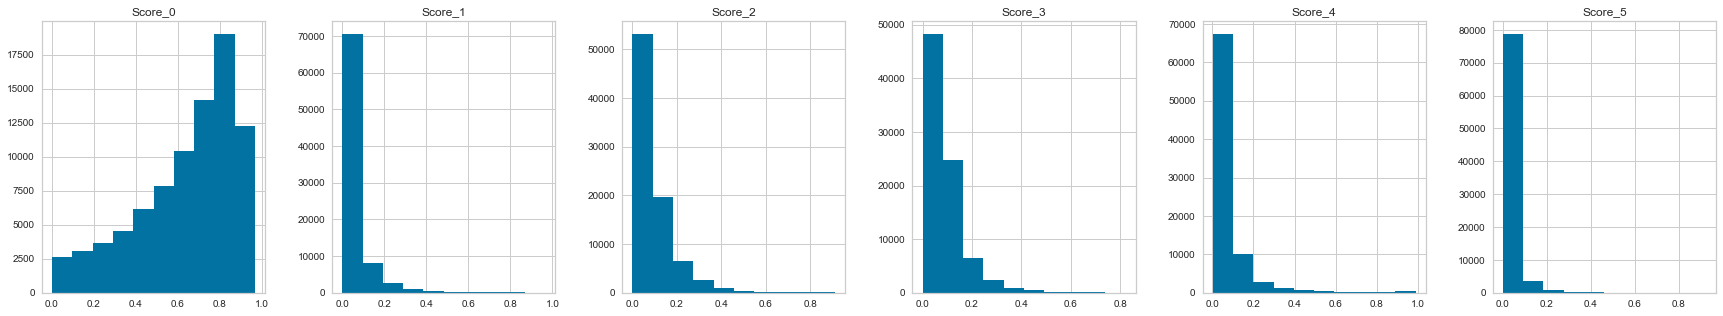

In [178]:
df_inference.hist(column=['Score_0', 'Score_1', 'Score_2', 'Score_3', 'Score_4', 'Score_5'], figsize=(30,5), layout=(1,6));

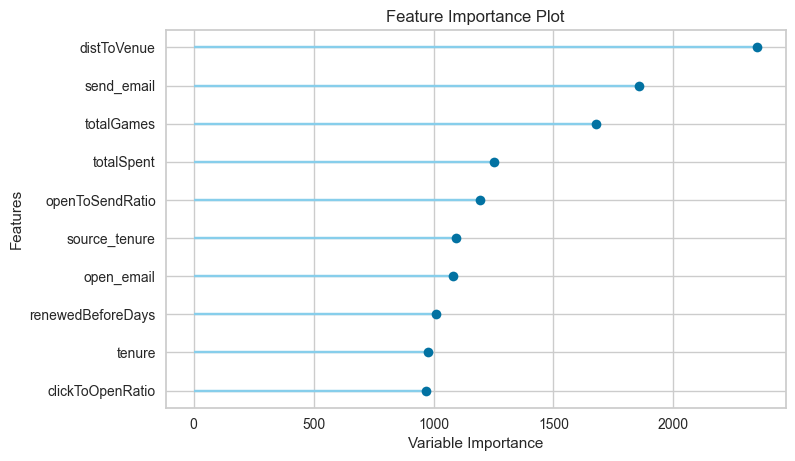

In [164]:
plot_model(best_model, plot='feature')

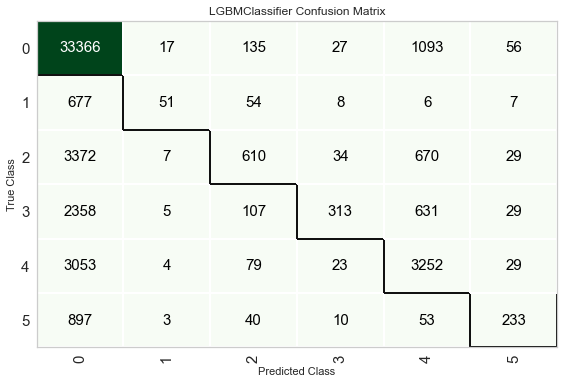

In [165]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.